In [44]:
import trimesh
import potpourri3d as pp3d
import numpy as np
import pyvista as pv
from scipy.spatial import KDTree
import gdist
import matplotlib.pyplot as plt

In [7]:
def unify_vertices(source_file_path, tolerance=1e-5):
    mesh = trimesh.load(source_file_path)
    
    vertices = mesh.vertices
    faces = mesh.faces

    # Step 1: Find unique vertices within the given tolerance
    kdtree = KDTree(vertices)
    unique_indices = {}
    canonical_vertices = []
    
    for i, vertex in enumerate(vertices):
        if i in unique_indices:
            continue  # Skip if already mapped to a canonical vertex
        
        # Find all vertices within the tolerance distance
        duplicate_indices = kdtree.query_ball_point(vertex, tolerance)
        
        # Use the first duplicate as the "canonical" vertex and map all duplicates to it
        canonical_index = len(canonical_vertices)
        canonical_vertices.append(vertex)
        
        for idx in duplicate_indices:
            unique_indices[idx] = canonical_index

    # Step 2: Update faces to use only unique vertices
    new_faces = np.array([[unique_indices[vi] for vi in face] for face in faces])

    # Step 3: Create the new unified mesh
    unified_mesh = trimesh.Trimesh(vertices=np.array(canonical_vertices), faces=new_faces)

    output_path = source_file_path[:-4] + '_fixed.obj'
    unified_mesh.export(output_path)
    print(f'Mesh unified and saved to {output_path}')

In [24]:
def remove_duplicate_edges(source_file_path):
        mesh = trimesh.load(source_file_path)

    edges = mesh.edges
    faces = mesh.faces
    sorted_edges = np.sort(edges, axis=1)

    # Find unique edges
    _, unique_indices = np.unique(sorted_edges, axis=0, return_index=True)
    unique_edges = edges[unique_indices]

    # Find the vertices used by unique edges
    unique_vertices = np.unique(unique_edges)

    # Remap vertices for the unique edges
    vertex_map = {old_index: new_index for new_index, old_index in enumerate(unique_vertices)}
    remapped_vertices = np.array([vertex_map[vertex] for vertex in unique_vertices])

    # Recreate the mesh using the unique edges and remapped vertices
    new_mesh = trimesh.Trimesh(vertices=mesh.vertices[remapped_vertices], faces=faces, process=False)

    output_path = source_file_path[:-4] + '_edges_cleaned.obj'
    new_mesh.export(output_path)
    print(f'Mesh cleaned and saved to {output_path}')


In [8]:
def remove_faces_by_indices(mesh, face_indices):
    # Convert face_indices to a set for fast exclusion
    face_indices_set = set(face_indices)

    # Create a mask that selects all faces except those we want to remove
    mask = [i not in face_indices_set for i in range(len(mesh.faces))]

    # Filter the faces array
    new_faces = mesh.faces[mask]

    # Recreate the mesh with the remaining faces
    new_mesh = trimesh.Trimesh(vertices=mesh.vertices, faces=new_faces, process=False)
    
    return new_mesh

In [40]:
# https://github.com/nmwsharp/robust-laplacians-py/issues/1
def add_random_jitter(source_file_path, level=1e-5, write_file=False):
    mesh = trimesh.load(source_file_path)
    jittered_vertices = mesh.vertices + np.random.normal(0, level, size= mesh.vertices.shape)
    unified_mesh = trimesh.Trimesh(vertices=jittered_vertices, faces= mesh.faces)
    if write_file:
        output_path = source_file_path[:-4] + '_jittered.obj'
        unified_mesh.export(output_path)
        print(f'Mesh jittered and saved to {output_path}')
    return unified_mesh
    

In [16]:
add_random_jitter('cow.obj', level=0.01)
#remove_duplicate_edges('dragon.obj')



Mesh jittered and saved to cow_jittered.obj


In [3]:
#mesh = trimesh.load('xyzrgb_dragon.obj')
mesh = trimesh.load('cow_jittered.obj')
#mesh_jittered = trimesh.load('dragon_jittered.obj')

# Set up the PyVista plotter
plotter = pv.Plotter()


'''
# Tests
troublesome_vertices = [34687, 34704]

involved_faces = []
for i, (x, y, z) in enumerate(mesh.faces):
    if 34687 in [x,y,z] or 34704 in [x,y,z]:
        involved_faces.append(i)
        #print(i)
#print(mesh.vertices.shape)
mesh = remove_faces_by_indices(mesh, involved_faces)
mesh.remove_unreferenced_vertices()
#print(mesh.vertices.shape)

#print(np.array(troublesome_vertices))
for vertex in troublesome_vertices:
    plotter.add_points(mesh.vertices[vertex].reshape(1, 3), color="blue", render_points_as_spheres=True, point_size=10)
'''

# Scalar heat method
source_vertex = 0
heat_solver = pp3d.MeshHeatMethodDistanceSolver(mesh.vertices, mesh.faces)
distances = heat_solver.compute_distance(source_vertex)
normalized_distances = (distances - distances.min()) / (distances.max() - distances.min())
faces_with_sizes = np.hstack([np.full((mesh.faces.shape[0], 1), 3), mesh.faces]).flatten()
pv_mesh = pv.PolyData(mesh.vertices, faces_with_sizes)
cmap = 
plotter.add_mesh(pv_mesh, scalars=normalized_distances, cmap='viridis', show_edges=True)
plotter.add_points(mesh.vertices[source_vertex].reshape(1, 3), color="red", render_points_as_spheres=True, point_size=10)


# Vector heat method
'''
source_vertex = 0
source_vector = (1, 0)
vector_solver = pp3d.MeshVectorHeatSolver(mesh.vertices, mesh.faces)

# Intrinsic vectors
intrinsic = vector_solver.transport_tangent_vector(source_vertex, source_vector)
basisX, basisY, basisN = vector_solver.get_tangent_frames()

# Extrinsic vectors
#ext = vector_solver.transport_tangent_vector(source_vertex, source_vector)
ext3D = intrinsic[:,0,np.newaxis] * basisX +  intrinsic[:,1,np.newaxis] * basisY
plotter.add_arrows(mesh.vertices, ext3D, mag=0.1)
'''

#mesh_jittered = remove_faces_by_indices(mesh_jittered, involved_faces)
#mesh_jittered.remove_unreferenced_vertices()
#vector_solver_2 = pp3d.MeshVectorHeatSolver(mesh_jittered.vertices, mesh_jittered.faces)
#vectors_jittered = vector_solver_2.transport_tangent_vector(source_vertex, source_vector)

plotter.show(title="Geodesic Distance Visualization")
plotter.close()

Widget(value='<iframe src="http://localhost:61061/index.html?ui=P_0x25c5528ca90_0&reconnect=auto" class="pyvis…

In [15]:
plotter.deep_clean()

In [4]:
#print(vectors[:10])
#print(vectors_jittered[:10])

distance_average = np.sum(np.abs(vectors-vectors_jittered))/vectors.shape[0]
print(f'Average distance: {distance_average}')

Average distance: 1.5772949929849003


In [49]:
plotter.show(title="Geodesic Distance Visualization")


Widget(value='<iframe src="http://localhost:62223/index.html?ui=P_0x1b2b3354940_16&reconnect=auto" class="pyvi…

In [41]:
def get_scalar_heat_geodesic(mesh, vertex_index):
    heat_solver = pp3d.MeshHeatMethodDistanceSolver(mesh.vertices, mesh.faces)
    return heat_solver.compute_distance(vertex_index)

In [42]:
def get_exact_geodesic(mesh, vertex_index):
    vertices = mesh.vertices
    faces = mesh.faces  # Mesh faces
    geodesic_distances = gdist.compute_gdist(
        vertices.astype(np.float64),
        faces.astype(np.int32),
        np.array([vertex_index], dtype=np.int32)  # Source vertex index
    )
    return geodesic_distances

In [43]:
def get_proximity(distances_exact, distances_approx):
    nonzero_mask = distances_exact > 0
    distances_exact_nonzero = distances_exact[nonzero_mask]
    distances_approx_nonzero = distances_approx[nonzero_mask]
    percentage_errors = np.abs(distances_exact_nonzero - distances_approx_nonzero) / distances_exact_nonzero * 100
    return np.mean(percentage_errors)

In [38]:
source_vertex = 0
exact_distances_no_noise = get_exact_geodesic('cow.obj', source_vertex)
shm_distances_no_noise = get_scalar_heat_geodesic('cow.obj', source_vertex)
exact_distances_with_noise = get_exact_geodesic('cow_jittered.obj', source_vertex)
shm_distances_with_noise = get_scalar_heat_geodesic('cow_jittered.obj', source_vertex)

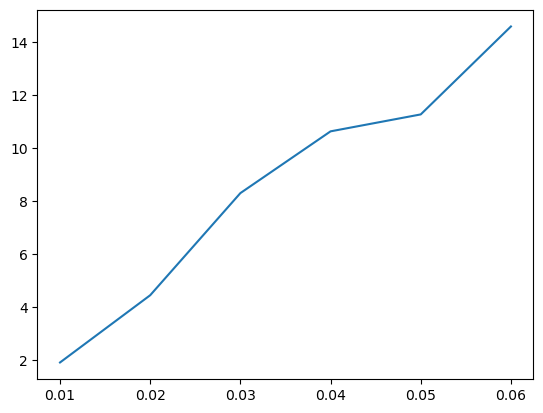

In [54]:
source_vertex = 0
obj_path = 'cow.obj'

noise_levels = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
proximities = []
for noise in noise_levels:
    jittered_mesh = add_random_jitter(obj_path, level=noise)
    exact_distances = get_exact_geodesic(jittered_mesh, source_vertex)
    shm_distances = get_scalar_heat_geodesic(jittered_mesh, source_vertex)
    proximities.append(get_proximity(exact_distances, shm_distances))
plt.plot(noise_levels, proximities)